In [1]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
from scipy.linalg import eig
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

import ModelFramework as mf
import ModelFramework.Elements as ele
import ModelFramework.ExternalForces as ef
import FwtModels.RectWing as rw
import FwtModels.RectWing.Models as rwm
import multiprocessing as mp

me.mechanics_printing()

In [2]:
%%time
b_modes = 3
t_modes = 3
model_num = 5

p = rw.base_params(b_modes+t_modes+2)
sm = mf.SymbolicModel.from_file(f'{b_modes}B{t_modes}T-M{model_num}.py')

CPU times: user 4.17 s, sys: 15 ms, total: 4.19 s
Wall time: 4.2 s


In [4]:
def Model_Eigen(model_num,b_modes,t_modes):
    print(model_num)
    p = rw.base_params(b_modes + t_modes + 2)
    sm = mf.SymbolicModel.from_file(f'{b_modes}B{t_modes}T-M{model_num}.py')
    
    dataset_name = 'JEC'
    # Set JEC Specific parameters
    p.rho.value = 1.225
    p.s_t.value = 1.345
    p.c.value = 0.15
    p.EI.value = 61
    p.GJ.value = 200
    p.rho_t.value = 10
    p.e_0.value = 0
    p.e_1.value = 0
    p.ratio_fwt.value = 0.2
    
    p.rho.value = 1.225
    p.s_t.value = 12
    p.c.value = 1.8
    p.EI.value = 9.77e6
    p.GJ.value = 0.99e6
    p.rho_t.value = 19.53
    p.e_0.value = 0.08
    p.e_1.value = 0  
    p.ratio_fwt.value = 0.2
    
    p.alpha_s.value = np.deg2rad(15)
    p.eta.value = [1]*p.qs
    p.m_ac.value = 1e6
    p.k_ac.value = 1e6
    p.k_fwt.value = 0
    
    vars_ls =[]
    vars_ls.append((p.Lambda,np.deg2rad([10,17.5,25])))
    vars_ls.append((p.V,np.linspace(0,80,81))) # V must be second
    vars_ls.append((p.alpha_r,np.deg2rad([0,5,10])))
    vars_ls.append((p.c_dmax,[0,0.5,1]))
    vars_ls.append((p.m_factor,[0.5,1,1.5]))
    vars_ls.append((p.k_fwt,[0,1e7]))

    variables = [k for k,v in vars_ls]
    
    calc_fixed = True if np.isin(2,np.array([1,2,3,4])) else False
    print(model_num)
    def Reduced_eqn(model):      
        f =  me.msubs(model.f-model.ExtForces.Q(),{i:0 for i in p.qd})
        f = sym.Matrix([0,*f[1:]])
        return f
    flutdf = rw.eigen_perm_params(p,sm,vars_ls,calc_fixed,jac=True,fixed_point_gen=Reduced_eqn)   
    print(model_num)
    flutdf.to_pickle(f'Eigen_{b_modes}B{t_modes}T-M{model_num}_{dataset_name}.pkl')

In [5]:
%%time
Model_Eigen(5,3,3)

5
5


/Users/fintan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


5
CPU times: user 2min 38s, sys: 1.11 s, total: 2min 39s
Wall time: 2min 40s


In [6]:
import pandas as pd
import seaborn as sns4

import numpy as np
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

In [8]:

flutdf = pd.DataFrame()
b_modes = 3
t_modes = 3

#dataset_name = 'JEC'
dataset_name = 'JEC'
#dataset_name = 'HALE'
#dataset_name = 'TestJEC'




model_names = {0:'Locked',1:'Free',2:'Free-IWT',3:'Free-IWT,IWB',4:'Free-IWT,IWB,FRotFWT',5:'Free-IWT,IWB,FRotFWT,Lin0',6:'Free-IWT,FRotFWT,Lin0'}
model_names = {0:'Old',1:'Old,Iyy',2:'New',3:'New,Iyy'}
model_names = {0:'Locked',1:'Free',2:'Free-IWT',3:'Free-IWT,IWB',4:'Free-IWT,IWB,FRotFWT',5:'Free-IWT,IWB,FRotFWT,Drag',6:'Free-IWT,IWB,FRotFWT,Lin0',7:'Free-IWT,IWB,FRotFWT,Drag,Lin0',6:'Free-IWT,FRotFWT,Lin0'}


ls = []
for i in [5]:
    dat = pd.read_pickle(f'Eigen_{b_modes}B{t_modes}T-M{i}_{dataset_name}.pkl')
    dat['Model'] = i
    dat['Config'] = dataset_name
    ls.append(dat)
    
flutdf = pd.concat(ls, ignore_index=True, sort=False)

flutdf = flutdf.reset_index(drop=True)
flutdf['Damping [%]'] = flutdf['Damping']*-100
flutdf['FWT Mass [%]'] = pd.Categorical(flutdf['delta_m']*100)
flutdf['Coast Angle [Deg]'] = np.rad2deg([i[-1] for i in flutdf['q']])
flutdf['Flare Angle [Deg]'] = pd.Categorical(np.rad2deg(flutdf['Lambda']))
flutdf['AoA [Deg]'] = pd.Categorical(np.rad2deg(flutdf['alpha_r']))
flutdf['Model'] = pd.Categorical(flutdf['Model'])
flutdf['Config'] = pd.Categorical(flutdf['Config'])
flutdf['Mode'] = pd.Categorical(flutdf['Mode'])
flutdf['Stable'] = pd.Categorical(flutdf['Stable'])
flutdf['Locked'] = pd.Categorical(flutdf['k_fwt']>0)

flutdf['c_dmax'] = pd.Categorical(flutdf['c_dmax'])
#flutdf['FWT Ratio [%]'] = pd.Categorical(flutdf['sigma']*100)
#flutdf['D/L'] = pd.Categorical(flutdf['sigma_DL'])

flutdf.head(50)

,Real,Imag,Frequency,Damping,Stable,Eigen Vector,Mode,Lambda,V,alpha_r,...,k_fwt,q,Model,Config,Damping [%],FWT Mass [%],Coast Angle [Deg],Flare Angle [Deg],AoA [Deg],Locked
0,0.000000,0.999819,0.159126,6.123234e-17,True,"[(-0.7071706948473647+0j), (-6.753186817962109...",0,0.174533,0.0,0.0,...,0.0,"[0.0, -0.001016580277584436, 6.353626734902634...",5,JEC,-6.123234e-15,50.0,90.000000,10.0,0.0,False
1,0.000000,2.476136,0.394089,6.123234e-17,True,"[-2.4050528710712314e-19j, 5.846607691450274e-...",1,0.174533,0.0,0.0,...,0.0,"[0.0, -0.001016580277584436, 6.353626734902634...",5,JEC,-6.123234e-15,50.0,90.000000,10.0,0.0,False
2,0.000000,16.211151,2.580085,6.123234e-17,True,"[0.0005267396730892403j, -0.05172146081620037j...",2,0.174533,0.0,0.0,...,0.0,"[0.0, -0.001016580277584436, 6.353626734902634...",5,JEC,-6.123234e-15,50.0,90.000000,10.0,0.0,False
3,0.000000,49.566372,7.888733,6.123234e-17,True,"[4.362228657502717e-06j, -8.115609451475318e-0...",3,0.174533,0.0,0.0,...,0.0,"[0.0, -0.001016580277584436, 6.353626734902634...",5,JEC,-6.123234e-15,50.0,90.000000,10.0,0.0,False
4,0.000000,107.990930,17.187290,6.123234e-17,True,"[5.486315960847334e-06j, -0.003312452035720368...",4,0.174533,0.0,0.0,...,0.0,"[0.0, -0.001016580277584436, 6.353626734902634...",5,JEC,-6.123234e-15,50.0,90.000000,10.0,0.0,False
5,0.000000,156.824461,24.959388,6.123234e-17,True,"[-7.453650276383326e-07j, -0.00038072635290008...",5,0.174533,0.0,0.0,...,0.0,"[0.0, -0.001016580277584436, 6.353626734902634...",5,JEC,-6.123234e-15,50.0,90.000000,10.0,0.0,False
6,0.000000,310.011103,49.339799,6.123234e-17,True,"[7.027979036287585e-07j, (-0-0.000164369982395...",6,0.174533,0.0,0.0,...,0.0,"[0.0, -0.001016580277584436, 6.353626734902634...",5,JEC,-6.123234e-15,50.0,90.000000,10.0,0.0,False
7,0.000000,565.650350,90.026049,6.123234e-17,True,"[5.160431995329461e-08j, -0.000515988854343262...",7,0.174533,0.0,0.0,...,0.0,"[0.0, -0.001016580277584436, 6.353626734902634...",5,JEC,-6.123234e-15,50.0,90.000000,10.0,0.0,False
8,-0.000036,0.999799,0.159123,-3.650636e-05,True,"[(0.00011846489701814734+0.7071779058267433j),...",0,0.174533,1.0,0.0,...,0.0,"[0.0, -0.0010165101808949813, 6.35318034899980...",5,JEC,3.650636e-03,50.0,89.863404,10.0,0.0,False
9,-0.047879,2.475667,0.394088,-1.933617e-02,True,[(-9.49491387478299e-05-2.0411194949305303e-05...,1,0.174533,1.0,0.0,...,0.0,"[0.0, -0.0010165101808949813, 6.35318034899980...",5,JEC,1.933617e+00,50.0,89.863404,10.0,0.0,False


In [9]:
def GetReducedDataSet(flutdf,model_num,Flare=25,AoA=0,ratio_FWT=20,theta = False,FWT_mass = 100,c_dmax = 0,Vmin = 1,Vmax = 140,Modes=None,Stable=None):
    data = flutdf.copy()
    data = data[cpo.SeriesFilter(data['Model'],model_num)]
    data = data[cpo.SeriesFilter(data['Flare Angle [Deg]'],Flare)]
    data = data[cpo.SeriesFilter(data['AoA [Deg]'],AoA)]
    data = data[cpo.SeriesFilter(data['FWT Mass [%]'],FWT_mass)]
    data = data[cpo.SeriesFilter(data['Mode'],Modes)]
    data = data[cpo.SeriesFilter(data['Stable'],Stable)]
    data = data[data['V']<=Vmax]
    data = data[data['V']>=Vmin]
    
    #data = data[SeriesFilter(data['FWT Ratio [%]'],ratio_FWT)]
    data = data[cpo.SeriesFilter(data['c_dmax'],c_dmax)]
    data = data[cpo.SeriesFilter(data['Locked'],theta)]
    return data

[1.]


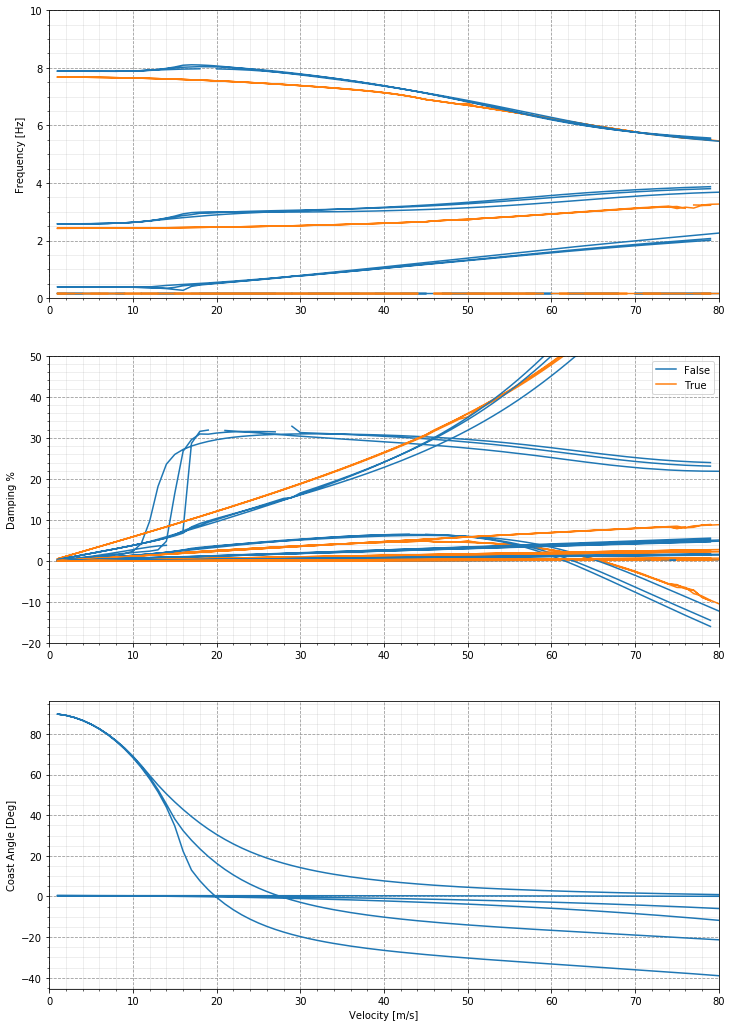

In [17]:
fig, axes = plt.subplots(3,1,figsize=(12,18))    

Tests = [5]
data = GetReducedDataSet(flutdf,Tests,ratio_FWT=None,theta = None,FWT_mass = [50],c_dmax = [1],Flare = 17.5,AoA = [0,5,10],Modes=None,Stable=None)

cpo.PlotLines(data,x = 'V',Modes = flutdf['Mode'].cat.categories,hue = 'Locked',y = 'Frequency',ax = axes[0])
cpo.PlotLines(data,x = 'V',Modes = flutdf['Mode'].cat.categories,hue = 'Locked',y = 'Damping [%]',ax = axes[1])
cpo.CoastDeltaPlot(data,'c_dmax', axes[2],Delta = False)
print(np.unique(data['c_dmax']))
for i in [0,1,2]:
    #axes[i].set(xlim=(0,60))
    axes[i].grid(b=True, which='major', color='#999999', linestyle='--')
    axes[i].minorticks_on()
    axes[i].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    axes[i].set(xlim=(0,80))
    

axes[0].set_ylabel('Frequency [Hz]')
axes[1].set_ylabel('Damping %')

#axes[0].set(ylim=(0.5,3))
axes[0].set(ylim=(0,10))
axes[1].set(ylim=(-20,50))    
#axes[2].set(ylim=(-1000,1000))  


#PlotModes(data,'Test',axes[:])
axes[1].legend([model_names[i] for i in Tests])
axes[1].legend(flutdf['Locked'].cat.categories)
#axes[1].legend(flutdf['AoA [Deg]'].cat.categories)
#fig.show()
#PlotModes(1,axes[:,0],Flare = 25)

In [13]:
p.rho.value = 1.225
p.s_t.value = 1.345
p.c.value = 0.15
p.EI.value = 61
p.GJ.value = 200
p.rho_t.value = 10
p.e_0.value = 0
p.e_1.value = 0
p.ratio_fwt.value = 0.2
p.alpha_s.value = np.deg2rad(15)
p.eta.value = [1]*p.qs
p.m_ac.value = 1e6
p.k_ac.value = 1e6

variables = [p.V,p.alpha_r,p.c_dmax,p.m_factor,p.Lambda,p.w_g,p.k_fwt,p.yaw]

sm_mini = sm.msubs({**p.GetSubs(None,None,ignore = variables),p.q[0]:0,p.qd[0]:0})
nm = sm_mini.CreateNumericModel(p)

f = me.msubs((sm_mini.f-sm_mini.ExtForces.Q()),{i:0 for i in p.qd})
func_obj = sym.lambdify((p.q,variables),f,"numpy") 

In [14]:
sm_mini.ExtForces.Q().free_symbols

In [34]:
p.V.value = 10
p.alpha_r.value = np.deg2rad(5)
p.c_dmax.value = 1
p.m_factor.value = 0.5
p.Lambda.value = np.deg2rad(10)
p.w_g.value = 0
p.k_fwt.value = 0
p.yaw.value = np.deg2rad(0)

values = [i.value for i in variables]

guess=[0]*(p.qs-1)
q = np.array([0]+list(fsolve(lambda q:func_obj([0]+list(q),values)[1:,0],guess,factor = 1)))

q


array([ 0.00000000e+00, -5.56653249e-02,  3.12890811e-02, -6.52717726e-03,
        2.95745426e-03, -1.37428172e-03,  6.19904776e-17,  1.01819841e+00])

In [35]:
x = [0]*p.qs*2
x[::2]=q
nm.deriv(0,x,p.GetNumericTuple(x,0))

In [41]:
%%time
p.V.value = 20
p.w_g.value = 0
p.m_factor.value = 0.5
p.k_fwt.value = 0
p.Lambda.value = np.deg2rad(10)
p.alpha_r.value = np.deg2rad(7)

b_shapes = 3

z,_ = mf.ShapeFunctions_BN_TM(b_shapes,0,p.q[1:b_shapes+1],p.y_0,0,0,0,p.eta[1:b_shapes+1])

d2z_dy2 = z.diff(p.y_0,p.y_0).subs(p.y_0,0)
z_tip = z.subs(p.y_0,p.s_0)
dz_dy_tip = z.diff(p.y_0).subs(p.y_0,p.s_0)

d2z_dy2_f = sym.lambdify((p.GetTuple(),p.q),d2z_dy2)
z_tip_f = sym.lambdify((p.GetTuple(),p.q),z_tip)
dz_dy_tip_f = sym.lambdify((p.GetTuple(),p.q),dz_dy_tip)


values = [i.value for i in variables]


q = np.array([0]+list(fsolve(lambda q:func_obj([0]+list(q),values)[1:,0],guess,factor = 1)))

print(np.rad2deg(dz_dy_tip_f(p.GetNumericTuple(q,0),q)))

def gust(t,x):
    T = 1
    if t<T:
        return 0.5*(1- np.cos(2*np.pi*t/T))
    else:
        return 0
    
p.w_g.value = gust
def objectiveDeriv(t,y):
    tup = p.GetNumericTuple(y,t)
    deriv = list(nm.deriv(t,y,tup))    
    #deriv[0] = deriv[1] = 0
    return tuple(deriv)
    
    

x0 = [0]*p.qs*2
x0[::2]=q


3.132471884865839
CPU times: user 35.1 ms, sys: 1.71 ms, total: 36.8 ms
Wall time: 35.7 ms


In [42]:
%%time
q = np.array([0]+list(fsolve(lambda q:func_obj([0]+list(q),values)[1:,0],guess,factor = 1)))

CPU times: user 1.79 ms, sys: 36 µs, total: 1.83 ms
Wall time: 1.81 ms


In [43]:
x = [0]*p.qs*2
x[::2]=q
nm.deriv(0,x,p.GetNumericTuple(x,0))

In [44]:
%%time
yData = solve_ivp(objectiveDeriv,(0,5),x)

CPU times: user 17.7 s, sys: 89.3 ms, total: 17.8 s
Wall time: 17.9 s


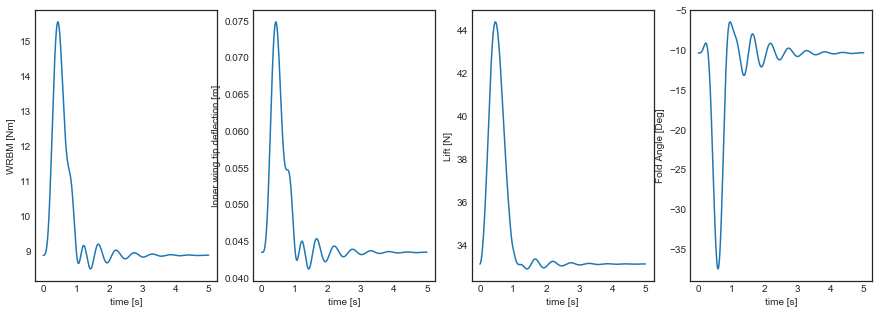

In [45]:
yi = yData.y
t = yData.t

b_shapes = 3
d2z_dy2 = z.diff(p.y_0,p.y_0).subs(p.y_0,0)
z_tip = z.subs(p.y_0,p.s_0)
dz_dy_tip = z.diff(p.y_0).subs(p.y_0,p.s_0)

d2z_dy2_f = sym.lambdify((p.GetTuple(),p.q),d2z_dy2)
z_tip_f = sym.lambdify((p.GetTuple(),p.q),z_tip)
dz_dy_tip_f = sym.lambdify((p.GetTuple(),p.q),dz_dy_tip)

lift = []
for i in range(len(t)):
    lift.append(nm.ExtForces(p.GetNumericTuple(yi[:,i],t[i]),yi[:,i],t[i])[0])

plt.style.use('seaborn-white')

tup = p.GetNumericTuple([0]*p.qs*2,0)

fig, axes = plt.subplots(1,4,figsize=(15,5))
axes[0].plot(t,d2z_dy2_f(tup,yi[::2])*p.EI.value)
axes[0].set_ylabel('WRBM [Nm]')
axes[0].set_xlabel('time [s]')

axes[1].plot(t,z_tip_f(tup,yi[::2]))
axes[1].set_ylabel('Inner wing tip deflection [m]')
axes[1].set_xlabel('time [s]')

axes[2].plot(t,lift)
axes[2].set_ylabel('Lift [N]')
axes[2].set_xlabel('time [s]')

axes[3].plot(t,np.rad2deg((yi[-2])+dz_dy_tip_f(tup,yi[::2])))
axes[3].set_ylabel('Fold Angle [Deg]')
axes[3].set_xlabel('time [s]')

yi[::2].shape

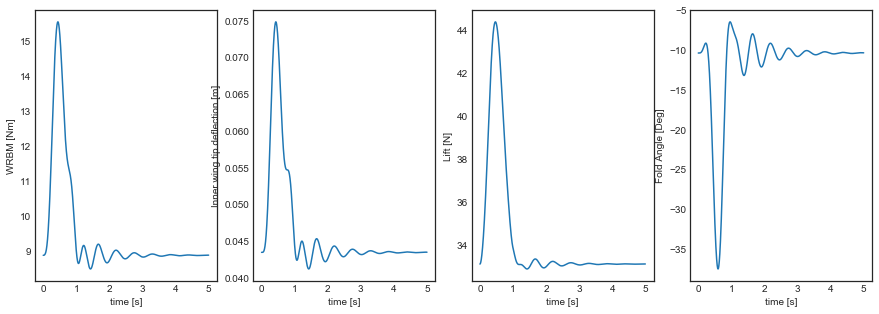

In [62]:
yi = yData.y
t = yData.t

b_shapes = 3
z,_ = mf.ShapeFunctions_BN_TM(b_shapes,0,p.q[1:b_shapes+1],p.y_0,0,0,0,p.eta[1:b_shapes+1])
d2z_dy2 = z.diff(p.y_0,p.y_0).subs(p.y_0,0)
z_tip = z.subs(p.y_0,p.s_0)
dz_dy_tip = z.diff(p.y_0).subs(p.y_0,p.s_0)

d2z_dy2_f = sym.lambdify((p.GetTuple(),p.q),d2z_dy2)
z_tip_f = sym.lambdify((p.GetTuple(),p.q),z_tip)
dz_dy_tip_f = sym.lambdify((p.GetTuple(),p.q),dz_dy_tip)

lift = []
for i in range(len(t)):
    lift.append(nm.ExtForces(p.GetNumericTuple(yi[:,i],t[i]),yi[:,i],t[i])[0])

plt.style.use('seaborn-white')

tup = p.GetNumericTuple([0]*p.qs*2,0)

fig, axes = plt.subplots(1,4,figsize=(15,5))
axes[0].plot(t,d2z_dy2_f(tup,yi[::2])*p.EI.value)
axes[0].set_ylabel('WRBM [Nm]')
axes[0].set_xlabel('time [s]')

axes[1].plot(t,z_tip_f(tup,yi[::2]))
axes[1].set_ylabel('Inner wing tip deflection [m]')
axes[1].set_xlabel('time [s]')

axes[2].plot(t,lift)
axes[2].set_ylabel('Lift [N]')
axes[2].set_xlabel('time [s]')

axes[3].plot(t,np.rad2deg((yi[-2])+dz_dy_tip_f(tup,yi[::2])))
axes[3].set_ylabel('Fold Angle [Deg]')
axes[3].set_xlabel('time [s]')

yi[::2].shape